# Crawl Data Analysis: Clustering

This notebook tries various clustering techniques on our web crawl data.

In [80]:
from __future__ import print_function
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os

## Read from database

Read the crawl data from the database. Here we read in the `site_visits` and `segments` tables and join them.

In [3]:
import sqlite3
import pandas as pd

db = '/n/fs/darkpatterns/crawl/2018-12-08_segmentation_pilot2/2018-12-08_segmentation_pilot2.sqlite'
con = sqlite3.connect(db)
site_visits = pd.read_sql_query('''SELECT * from site_visits''', con)

In [4]:
print('Number of site visits: %s' % str(site_visits.shape))
print('site_visits columns: %s' % str(list(site_visits.columns.values)))

Number of site visits: (2839, 3)
site_visits columns: ['visit_id', 'crawl_id', 'site_url']


Report how many unique domains we have.

In [5]:
from urlparse import urlparse

site_visits['domain'] = site_visits['site_url'].apply(lambda x: urlparse(x).netloc)
grouped = site_visits.groupby(['domain']).count().sort_values('visit_id', ascending=False)

In [6]:
print('Number of unique domains: %s' % str(grouped.shape[0]))

Number of unique domains: 630


In [7]:
segments = pd.read_sql_query('''SELECT * from segments''', con)

In [8]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (1124037, 22)
segments columns: ['id', 'crawl_id', 'visit_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp']


In [9]:
segments = segments.reset_index().set_index('visit_id').join(site_visits.reset_index()[['visit_id', 'site_url', 'domain']].set_index('visit_id'), how='inner')

## Preprocess data

Ignore `body` tags and null `inner_text`, and add columns for number of newlines and length of `inner_text`.

In [10]:
segments['inner_text'] = segments['inner_text'].str.strip()
segments = segments[(segments['node_name'] != 'BODY') & (segments['inner_text'] != '')]
segments['newline_count'] = segments['inner_text'].apply(lambda x: len(x.split('\n')))
segments['inner_text_length'] = segments['inner_text'].apply(lambda x: len(x))

In [11]:
print('segments[\'newline_count\'].describe(): \n %s' % segments['newline_count'].describe().to_string())
print('segments[\'inner_text_length\'].describe(): \n %s' % segments['inner_text_length'].describe().to_string())

segments['newline_count'].describe(): 
 count    740532.000000
mean          3.981557
std          55.266438
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        5002.000000
segments['inner_text_length'].describe(): 
 count    740532.000000
mean        108.879522
std        3206.474593
min           1.000000
25%           5.000000
50%          14.000000
75%          35.000000
max      391699.000000


Replace numbers with a placeholder.

In [12]:
segments['inner_text_processed'] = segments['inner_text'].str.replace(r'\d+', 'DPNUM')
segments['longest_text_processed']= segments['longest_text'].str.replace(r'\d+', 'DPNUM')

Remove redundant segments.

In [13]:
segments = segments.groupby(['domain']).apply(lambda x: x.drop_duplicates(subset=['inner_text_processed'], keep='last'))

In [83]:
print('Number of segments: %s' % str(segments.shape))
print('segments columns: %s' % str(list(segments.columns.values)))

Number of segments: (75516, 28)
segments columns: ['index', 'id', 'crawl_id', 'node_name', 'node_id', 'top', 'left', 'width', 'height', 'style', 'inner_text', 'outer_html', 'longest_text', 'longest_text_width', 'longest_text_height', 'longest_text_top', 'longest_text_left', 'longest_text_style', 'num_buttons', 'num_imgs', 'num_anchors', 'time_stamp', 'site_url', 'domain', 'newline_count', 'inner_text_length', 'inner_text_processed', 'longest_text_processed']


## Create feature vectors

First we define the a function to tokenize text as we convert text into feature vectors. 

In [15]:
from nltk.stem.porter import PorterStemmer
import nltk

nltk.download('stopwords')

stemmer = PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')

def tokenize(line):
    if (line is None):
        line = ''
    tokens = [stemmer.stem(t) for t in nltk.word_tokenize(line) if len(t) != 0 and t not in stopwords and not t.isdigit()]
    return tokens

[nltk_data] Downloading package stopwords to /u/mjf4/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now select one of the following cells to run to create a feature representation. Either load from the pre-existing file or recompute the features.

### 1. Bag of words

In [21]:
if os.path.isfile('features_bow.npy'):
    features = np.load('features_bow.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

No pre-existing file


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

data = segments['inner_text_processed']
vec = CountVectorizer(tokenizer=tokenize, binary=binary_rep, strip_accents='ascii').fit(data)

In [ ]:
print('Length of vocabulary %s' % str(len(vec.vocabulary_)))

In [ ]:
vec = vec.transform(data)
features = normalize(vec, axis=0)
np.save('features_bow.npy', features)

### 2. TFIDF

In [61]:
if os.path.isfile('features_tfidf.npy'):
    features = np.load('features_tfidf.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

Loaded from file


In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
data = segments['inner_text_processed']
vec = TfidfVectorizer(tokenizer=tokenize, binary=False, strip_accents='ascii').fit(data)
features = vec.transform(data)
np.save('features_tfidf.npy', features)

[nltk_data] Downloading package punkt to /u/mjf4/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
print('Length of vocabulary %s' % str(len(vec.vocabulary_)))
print('features shape (num_examples, num_features): %s' % str(features.shape))

Length of vocabulary 51257
features shape (num_examples, num_features): (1000, 51257)


### 3. Word Vectors

We compute a vector for each segment as follows: compute the word vector for each word in the segment's `inner_text`, and then average over all words in that segment.

While it's simple, there are clearly downsides to this approach:

- We lose information about word ordering
- All words are equally weighted, so words that really characterize the text are not prioritized

In [22]:
if os.path.isfile('features_wordvec.npy'):
    features = np.load('features_wordvec.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

No pre-existing file


In [89]:
import en_core_web_sm

data = segments['inner_text_processed']
nlp = en_core_web_sm.load()
vecs = []
for doc in nlp.pipe(data.str.replace(r'\d+', '').astype('unicode').values, batch_size=10000, n_threads=7):
    if doc.is_parsed:
        vecs.append(doc.vector)
    else:
        vecs.append(None)
features = np.array(vecs)

In [90]:
np.save('features_wordvec.npy', features)

In [91]:
print('features shape: %s' % str(features.shape))

features shape: (75516, 128)


### PCA
Try using PCA to reduce the dimension of the data.

The feature matrix is expected to be provided with examples in rows (`num_examples` x `num_features`).

In [46]:
if os.path.isfile('features_proj.npy'):
    features = np.load('features_proj.npy')
    print('Loaded from file')
else:
    print('No pre-existing file')

No pre-existing file


In [94]:
# TEMPORARY: Take a subset of the features before doing pca, for speed
features_orig = np.copy(features)
indices = np.random.choice(np.arange(features.shape[0]), size=1000, replace=False)
features = features[indices,:]

In [95]:
print('features shape: %s' % str(features.shape))
print('features_orig shape: %s' % str(features_orig.shape))

features shape: (1000, 128)
features_orig shape: (75516, 128)


In [96]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=3)
# pca = PCA(tol=1e-5)
pca.fit(features)

TruncatedSVD(algorithm='randomized', n_components=3, n_iter=5,
       random_state=None, tol=0.0)

In [97]:
print('Matrix of PCs: %s' % str(pca.components_.shape))
print('Data matrix: %s' % str(features.shape))

Matrix of PCs: (3, 128)
Data matrix: (1000, 128)


Projected data is given by $U^T X$, where $U$ is matrix with PCs in columns (`orig_dim` x `reduced_dim`), and $X$ is the data matrix with examples in columns (`orig_dim` x `num_examples`). In our case, $U^T$ is `pca.components_` and $X$ is `features.T`.

In [98]:
features = np.dot(pca.components_, features.T)

In [99]:
np.save('features_proj.npy', features)

In [100]:
print('feature matrix shape (after PCA): %s' % str(features.shape))
print('singular values of the first 3 PCs: %s' % str(pca.singular_values_))

feature matrix shape (after PCA): (3, 1000)
singular values of the first 3 PCs: [349.6205  150.13757 120.87865]


Plot the data in the reduce dimension.

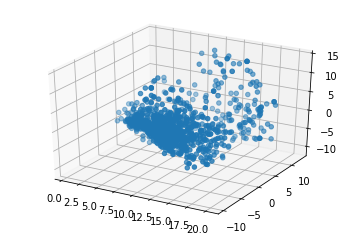

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(features[0,:], features[1,:], features[2,:])

## Clustering

Run one of the following clustering algorithms.

### 1. Hierarchical clustering

In [ ]:
from scipy.spatial import distance
import fastcluster

featdense = features.todense()
distances = distance.pdist(featdense, metric='cosine')
distances = distance.squareform(distances, checks=False)

In [ ]:
clusters = fastcluster.linkage(distances, method='ward', preserve_input=False)
np.save('linkage.matrix', clusters)

Plot a dendogram of the resulting clusters.

In [ ]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    clusters,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

### 2. DBSCAN clustering

In [ ]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10, metric='cosine')
cluster_labels = clusterer.fit(features)
segments['cluster'] = pd.Series(cluster_labels.labels_).values

In [ ]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

### 3. HDBSCAN clustering

In [ ]:
from sklearn.preprocessing import normalize
import hdbscan

features = normalize(features, axis=1) # Normalize each segment since using euclidean distance metric
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean')
cluster_labels = clusterer.fit_predict(features)
segments['cluster'] = pd.Series(cluster_labels).values

In [ ]:
print('segments[\'cluster\'].value_counts(): \n %s' % segments['cluster'].value_counts().to_string())

## Visualize results

Produce a CSV file that shows the segments in each cluster.

In [ ]:
inner_texts = segments['inner_text']
cluster_labels = segments['cluster']
print("segments['inner_text'] is %s, segments['cluster'] is %s (should be the same)" % (str(inner_texts.shape), str(cluster_labels.shape)))
assert inner_texts.shape == cluster_labels.shape

Group the segments by cluster.

In [ ]:
from collections import defaultdict

segments_by_cluster = defaultdict(lambda: [])
for i in range(inner_texts.shape[0]):
segments_by_cluster[str(cluster_labels[i])].append(inner_texts[i])

Write CSV file.

In [ ]:
import unicodecsv as csv

outfile = 'clusters.csv'
with open(outfile, 'wb') as f:
writer = csv.writer(f)
for cluster, segments in segments_by_cluster.iteritems():
    segments_str = '\n\n'.join(segments)
    writer.writerow([cluster, segments_str])